# Intro to Regression

We're going through a few regression exercises that will help you see how regression works in Python.  

## Objectives: At the end of this notebook the students should:
- Be able to further visualize data
- Look for correlations and multicollinearity
- Create linear regression model using statsmodels
- Interpret basic regression statistics like R^2
- Do basic feature engineering and selection to improve models
- Learn how to create and tune model using sklearn
- Create train and test set to begin properly measuring strength of model



Be able to create linear regression in:
- [***statsmodels***](http://statsmodels.sourceforge.net/): a package mainly best at doing regressions with traditional R formula syntax
- [***scikit-learn***](http://scikit-learn.org/dev/index.html): This is a very popular machine learning package you will probably use moving forward as you experiment with more advanced machine learning models.  It has a multitude of machine learning algorithms and helpful machine learning pipeline tools.  sklearn has a tremendous amount of functionality, to get the most out of this course it will help to really explore the depth of the documentation on your own.


Gain familiarity with the following:
- ***R formulas***: R formulas are a convenient way for encapsulating functional relationships for regressions
- [***seaborn***](http://stanford.edu/~mwaskom/software/seaborn/): We'll use seaborn for **visualization** as we go along


## Datasets
We'll take a look at a few different datasets:
1. [Survey Responses](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) (done together)
2. Manufactured random dataset  (done together)
3. [Car price predictor dataset](https://archive.ics.uci.edu/ml/datasets/Automobile) (as exercise)

# Setup
Try running the following imports and check that they all import successfully.  If they do not, install commands are given below. If necessary, at a command line window use `pip` to install the ones that are failing for you and then retry the imports.

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Survey Data
We will use this [simple survey data](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) to demonstrate a few basic features of ***statsmodels*** and ***seaborn*** and how they might be used in a data science workflow for regression.

The dataset is simply the results of a survey where the question responses are all numeric.  This leads to 6 numeric independent variable (predictor) fields and 1 numeric dependent variable (response) field.  The predictors are labeled ***X<sub>i</sub>*** and the response is labeled ***Y***.

Let's load the dataset in using ***pandas*** and take a look at it

In [2]:
# Load data

df = pd.read_csv('https://stats.idre.ucla.edu/wp-content/uploads/2016/02/p054.txt', sep='\t')
# Take a look at the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
Y      30 non-null int64
X1     30 non-null int64
X2     30 non-null int64
X3     30 non-null int64
X4     30 non-null int64
X5     30 non-null int64
X6     30 non-null int64
dtypes: int64(7)
memory usage: 1.8 KB


In [3]:
# Take a look at the first few rows
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


If we look at the column names, we'll notice we have the trailing whitespace problem.

In [4]:
df.columns

Index(['Y ', 'X1 ', 'X2 ', 'X3 ', 'X4 ', 'X5 ', 'X6 '], dtype='object')

We can remove this by calling map on the columns list and stripping the whitespace with strip

In [5]:
df.columns = df.columns.map(str.strip)
df.columns

Index(['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')

In [6]:
# How many rows and columns does the dataset have?
df.shape

(30, 7)

### Visualizing with Seaborn
We see that the data has 30 responses with 7 fields (6 independent, 1 dependent) each.  Let's use pandas to check out the correlations between the different variables.

We have discussed correlation measures and some plotting functions already. We will now look to adding to that skillset to get a deeper understanding in our survey use case

In [7]:
# View the correlations
df.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.825418,0.426117,0.623678,0.590139,0.156439,0.155086
X1,0.825418,1.000000,0.558288,0.596736,0.669197,0.187714,0.224580
X2,0.426117,0.558288,1.000000,0.493331,0.445478,0.147233,0.343293
X3,0.623678,0.596736,0.493331,1.000000,0.640314,0.115965,0.531620
X4,0.590139,0.669197,0.445478,0.640314,1.000000,0.376883,0.574186
X5,0.156439,0.187714,0.147233,0.115965,0.376883,1.000000,0.283343
X6,0.155086,0.224580,0.343293,0.531620,0.574186,0.283343,1.000000


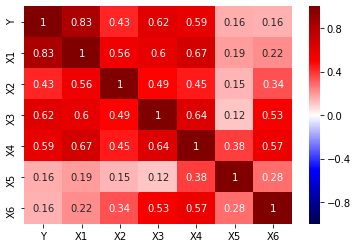

In [8]:
# example of a better corr matrix
# Here we are using one of seaborns built in statistical plots
# Seaborn is built on top of matplotlib and provides great built-in visualizations for statistical workflow
sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

### Correlation and Multicollinearity
We notice that some of the variables are highly correlated.  This is something we might want to take into consideration later.  When 2 predictor variables are highly correlated this is called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and it is something we want to watch out for as it can destabilize our model.  In the extreme case, when 2 predictors are perfectly correlated then there is absolutely nothing gained by making both variables part of our regression.

The other takeaway from this table is that some of our predictors are highly correlated with our ***target variable Y***.  This is a good thing, it means that these are the variables that we most likely want to include as part of our model as they explain a large amount of the variance in the target variable (correlation=R, variance_explained=R<sup>2</sup>).

Let's try to visualize these correlations all together by using the [***seaborn pairplot***](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html) function.

> What do you notice?

> Almost all correlations are positive, somewhat normal distributions, etc.

<img src="r-squared.png">

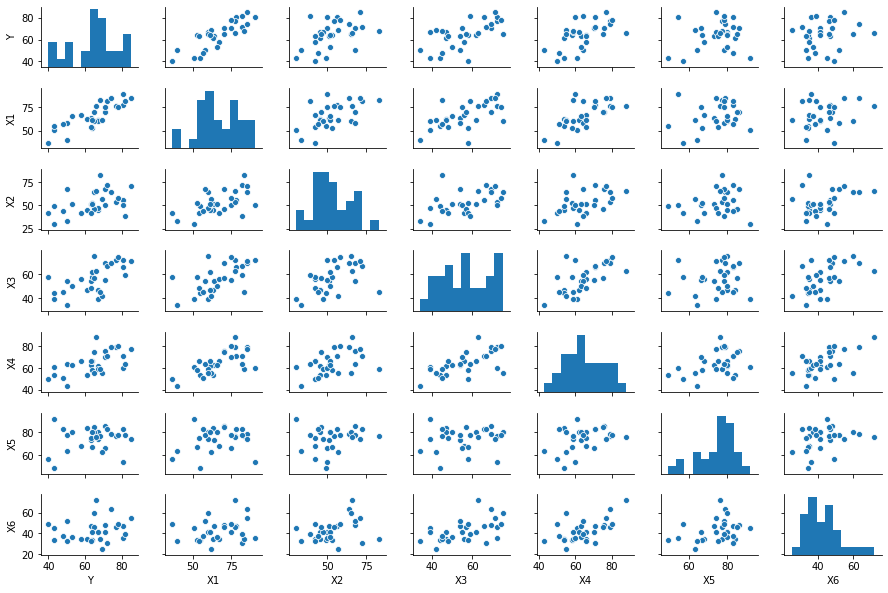

In [9]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df, height=1.2, aspect=1.5);

### Ordinary Least Squares Regression with Statsmodels
Now that we have a feel for our data, let's jump right in and try a basic regression model.  

#### Statsmodels
We are going to use the [**`statsmodels`**](http://statsmodels.sourceforge.net/) library first.  `statsmodels` is a Python package for implementing [**linear models**](https://en.wikipedia.org/wiki/Linear_model), of which **Linear Regression** is one.  It has a bunch of nice features for evaluating and executing such models.  Essentially, a linear model is one that is a **linear function of the parameters**.  For Linear Regression, this means the parameter $\beta$ (note that here $\beta$ is a **vector** of parameters, which includes $\beta_0$, $\beta_1$, $\beta_2$, etc).  
#### Modeling with Statsmodels
We are going to use the `statsmodels.formula.api` package

Here we will need somewhere to use the R formula styles formulas for defining the relationship between target variable and feature variables in our model.  

Here we'll just start by defining a regression model that takes as its inputs each of the 6 predictor variables.  The other parameter of course is the data that the model is to be built from, our pandas dataframe.

This first model fitting is done for you, it fits a multiple linear regression model of the following form (notice the use of [MathJax](https://www.mathjax.org/) for rendering such lovely math equations in markdown):

$$
\widehat{Y} = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_4 + \beta_5X_5 + \beta_6X_6
$$



In [10]:
# Define the model
lm1 = smf.ols('Y ~ X1 + X2 + X3 + X4 + X5 + X6', data=df)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     10.50
Date:                Thu, 30 Jan 2020   Prob (F-statistic):           1.24e-05
Time:                        16:43:09   Log-Likelihood:                -97.250
No. Observations:                  30   AIC:                             208.5
Df Residuals:                      23   BIC:                             218.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7871     11.589      0.931      0.362     -13.187      34.761
X1             0.6132      0.161      3.809      0.001       0.280       0.946
X2            -0.0731      0.136     -0.538      0.596      -0.354       0.208
X3             0.3203      0.169      1.901      0.070      -0.028       0.669
X4             0.0817      0.221      0.369      0.715      -0.376       0.540
X5             0.0384      0.147      0.261      0.796      -0.266       0.342
X6            -0.2171      0.178     -1.218      0.236      -0.586       0.152
==============================================================================
Omnibus:                        2.386   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.255
Skew:                          -0.081   Prob(JB):                        0.534
Kurtosis:                       2.011   Cond. No.                     1.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
df.columns

Index(['Y', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6'], dtype='object')

## Regression Statistics
From this we get a handful of useful statistics describing our regression. A google search on statistics should yield further details for those interested. We will focus on the ***R<sup>2</sup>*** values and the middle table here.

***R<sup>2</sup>*** is the square of the correlation coefficient and represents the estimated percentage of the variance in our target variable ***Y*** that can be explained by our regression model.  ***Adjusted R<sup>2</sup>*** also penalizes for things such as large coefficients and extra variables to try and limit ***overfitting*** so it is often a better measure of model efficacy. We will use that here.

The middle table provides the **coefficients** that our regression has found, along with the **standard error** for each coefficient. This defines our model, aka these are the model parameters that our algorithm was seeking to determine.  

The **t-scores** are values that the coefficients score in the [Student's T Distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) and the **P>|t|** field represents the probability of finding such a t-score if the actual value of the coefficient were 0. In other words, if we had a coefficient whose true value should be 0 (aka the predictor has no impact on the response) then this P-value is the probability of finding such a coefficient value in our regression by random chance. In essence, it measures our degree of belief that the coefficient for each variable should be zero. Thus, the lowest P-values represent the most likely predictors to be impacting the response.

## Exercise

Putting it all together, the final column returns a **95% Confidence Interval** for the value of each coefficient.

Given these stats, lets remove the highest 3 P-values from our regression model, from ***X<sub>2</sub>***, ***X<sub>4</sub>***, and ***X<sub>5</sub>*** and see how our model performs now:

In [12]:
# STUDENT SECTION
# Define the model removing X2, X4, and X5
lm2 = smf.ols('Y ~ X1 + X3 + X6', data=df)

# Fit the model
fit2 = lm2.fit()

# Check out the results
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     22.92
Date:                Thu, 30 Jan 2020   Prob (F-statistic):           1.81e-07
Time:                        16:43:10   Log-Likelihood:                -97.638
No. Observations:                  30   AIC:                             203.3
Df Residuals:                      26   BIC:                             208.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.5777      7.544      1.800      0.084      -1.929      29.084
X1             0.6227      0.118      5.271      0.000       0.380       0.866
X3             0.3124      0.154      2.026      0.053      -0.005       0.629
X6            -0.1870      0.145     -1.291      0.208      -0.485       0.111
==============================================================================
Omnibus:                        2.856   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                1.394
Skew:                          -0.121   Prob(JB):                        0.498
Kurtosis:                       1.972   Cond. No.                         605.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You should see our **Adjusted R<sup>2</sup>** has increased, and our P-values are lower so we likely have a better model.  Let's just try removing ***X<sub>6</sub>*** to see if that might improve our model a little bit more.

In [13]:
# STUDENT SECTION
# Define the model removing X6 this time
lm3 = smf.ols('Y ~ X1 + X3', data=df)

# Fit the model
fit3 = lm3.fit()

# Check out the results
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     32.74
Date:                Thu, 30 Jan 2020   Prob (F-statistic):           6.06e-08
Time:                        16:43:10   Log-Likelihood:                -98.569
No. Observations:                  30   AIC:                             203.1
Df Residuals:                      27   BIC:                             207.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.8709      7.061      1.398      0.174      -4.618      24.359
X1             0.6435      0.118      5.432      0.000       0.400       0.887
X3             0.2112      0.134      1.571      0.128      -0.065       0.487
==============================================================================
Omnibus:                        6.448   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                1.959
Skew:                          -0.041   Prob(JB):                        0.375
Kurtosis:                       1.751   Cond. No.                         503.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both **R<sup>2</sup>** and **adjusted R<sup>2</sup>** have dropped, so keeping ***X<sub>1</sub>***, ***X<sub>3</sub>*** and ***X<sub>6</sub>*** seems best.

Out of curiousity, try linear regression with just ***X<sub>1</sub>***. 

In [14]:
# STUDENT SECTION
# Define the model removing all but X1
lm4 = smf.ols('Y ~ X1', data=df)

# Fit the model
fit4 = lm4.fit()

# Check out the results
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     59.86
Date:                Thu, 30 Jan 2020   Prob (F-statistic):           1.99e-08
Time:                        16:43:10   Log-Likelihood:                -99.882
No. Observations:                  30   AIC:                             203.8
Df Residuals:                      28   BIC:                             206.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.3763      6.620      2.172      0.039       0.816      27.937
X1             0.7546      0.098      7.737      0.000       0.555       0.954
==============================================================================
Omnibus:                        7.462   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                2.537
Skew:                          -0.331   Prob(JB):                        0.281
Kurtosis:                       1.739   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 **Adjusted R<sup>2</sup>** dropped further, but model with just ***X<sub>1</sub>*** still has a higher **adjusted R<sup>2</sup>** than the full model. More isn't always better. 

Since we've gone this far, what happens when we remove the intercept?

In [15]:
# STUDENT SECTION
# Define the model removing all but X1
lm5 = smf.ols('Y ~ X1 -1', data=df)

# Fit the model
fit5 = lm5.fit()

# Check out the results
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Y   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                              2320.
Date:                Thu, 30 Jan 2020   Prob (F-statistic):                    3.13e-29
Time:                        16:43:10   Log-Likelihood:                         -102.22
No. Observations:                  30   AIC:                                      206.4
Df Residuals:                      29   BIC:                                      207.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X1             0.9624      0.020     48.170      0.000       0.922       1.003
==============================================================================
Omnibus:                        7.167   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                2.053
Skew:                          -0.047   Prob(JB):                        0.358
Kurtosis:                       1.722   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both **R<sup>2</sup>** and **adjusted R<sup>2</sup>** have increased to almost 1. What is going on?

The fit hasn't dramatically improved. The issue is that **R<sup>2</sup>** and **adjusted R<sup>2</sup>** are calculated differently without an intercept, so these parameters don't offer a useful basis for comparison of models with and without intercept. See for example https://stats.stackexchange.com/questions/26176/removal-of-statistically-significant-intercept-term-increases-r2-in-linear-mo 



### Plotting Residuals
Before we call it a day with this model and dataset, let's take a quick look at a plot of our residuals *(actual value - predicted value)* with this model.  We do this because in a good model we essentially want our errors to be random.  If our residuals look systematic (e.g. missing high for one range and low for another) then we probably are missing the actual functional dependency underlying the data (perhaps it's not really linear).

Take a look [here](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit) for an example of a bad residual plot.

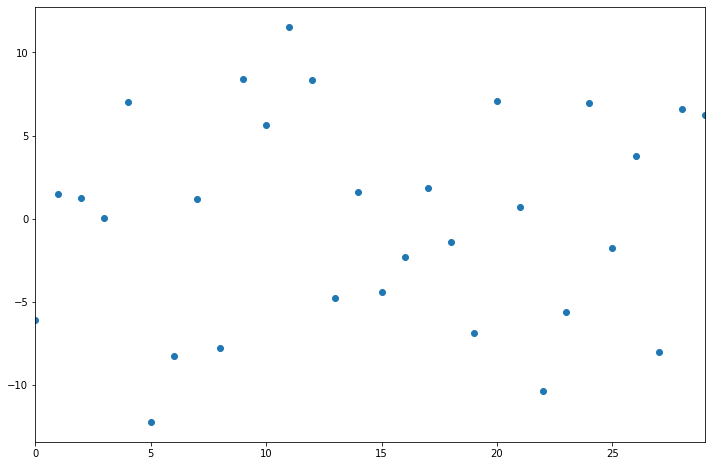

In [16]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(12,8));

In [17]:
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     59.86
Date:                Thu, 30 Jan 2020   Prob (F-statistic):           1.99e-08
Time:                        16:43:10   Log-Likelihood:                -99.882
No. Observations:                  30   AIC:                             203.8
Df Residuals:                      28   BIC:                             206.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.3763      6.620      2.172      0.039       0.816      27.937
X1             0.7546      0.098      7.737      0.000       0.555       0.954
==============================================================================
Omnibus:                        7.462   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                2.537
Skew:                          -0.331   Prob(JB):                        0.281
Kurtosis:                       1.739   Cond. No.                         352.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""